In [9]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor


simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

# Load Stock dataset
industries = ["Close", "Volume"]
stock = pd.read_csv("../ALBRK.csv", 
                    parse_dates=['Date'], 
                    index_col='Date', 
                    usecols=["Date"] + industries
                   ).to_period('D').reindex(columns=industries)
print(stock.head())

stock = pd.concat({'Stock': stock}, names=[None, 'Columns'], axis=1)
stock.head()

               Close    Volume
Date                          
2010-01-01  1.196240         0
2010-01-04  1.196240    758454
2010-01-05  1.244736   9420657
2010-01-06  1.282456   7354184
2010-01-07  1.309398  12078601


Stock          
Columns        Close    Volume
Date                          
2010-01-01  1.196240         0
2010-01-04  1.196240    758454
2010-01-05  1.244736   9420657
2010-01-06  1.282456   7354184
2010-01-07  1.309398  12078601

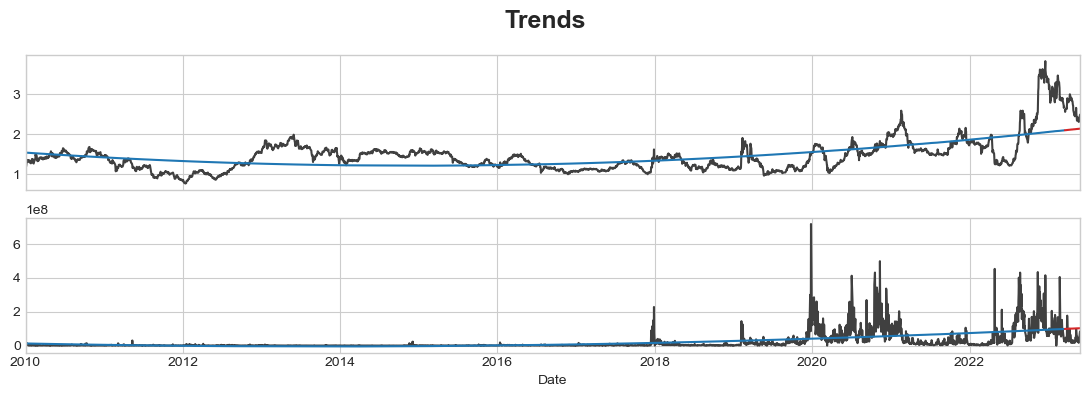

In [10]:
y = stock.copy()

# Create trend features
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,  # the intercept
    order=2,        # quadratic trend
    drop=True,      # drop terms to avoid collinearity
)
X = dp.in_sample()  # features for the training data

# Test on the years 2016-2019. It will be easier for us later if we
# split the date index instead of the dataframe directly.
idx_train, idx_test = train_test_split(
    y.index, test_size=12 * 4, shuffle=False,
)
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

# Fit trend model
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

# Make predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)
y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

# Plot
axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")

In [3]:
print(stock.head())
# The `stack` method converts column labels to row labels, pivoting from wide format to long
X = stock.stack()  # pivot dataset wide to long
display(X.head())


               Stock          
Columns        Close    Volume
Date                          
2010-01-01  1.196240         0
2010-01-04  1.196240    758454
2010-01-05  1.244736   9420657
2010-01-06  1.282456   7354184
2010-01-07  1.309398  12078601


Stock
Date       Columns               
2010-01-01 Close         1.196240
           Volume        0.000000
2010-01-04 Close         1.196240
           Volume   758454.000000
2010-01-05 Close         1.244736

In [4]:
y = X.pop('Stock')  # grab target series

In [5]:
# Turn row labels into categorical feature columns with a label encoding
X = X.reset_index('Columns')
# Label encoding for 'Industries' feature
for colname in X.select_dtypes(["object", "category"]):
    X[colname], _ = X[colname].factorize()

# Label encoding for annual seasonality
X["Month"] = X.index.month  # values are 1, 2, ..., 12

# Create splits
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

In [6]:
# Pivot wide to long (stack) and convert DataFrame to Series (squeeze)
y_fit = y_fit.stack().squeeze()    # trend from training set
y_pred = y_pred.stack().squeeze()  # trend from test set

# Create residuals (the collection of detrended series) from the training set
y_resid = y_train - y_fit

# Train XGBoost on the residuals
xgb = XGBRegressor()
xgb.fit(X_train, y_resid)

# Add the predicted residuals onto the predicted trends
y_fit_boosted = xgb.predict(X_train) + y_fit
y_pred_boosted = xgb.predict(X_test) + y_pred

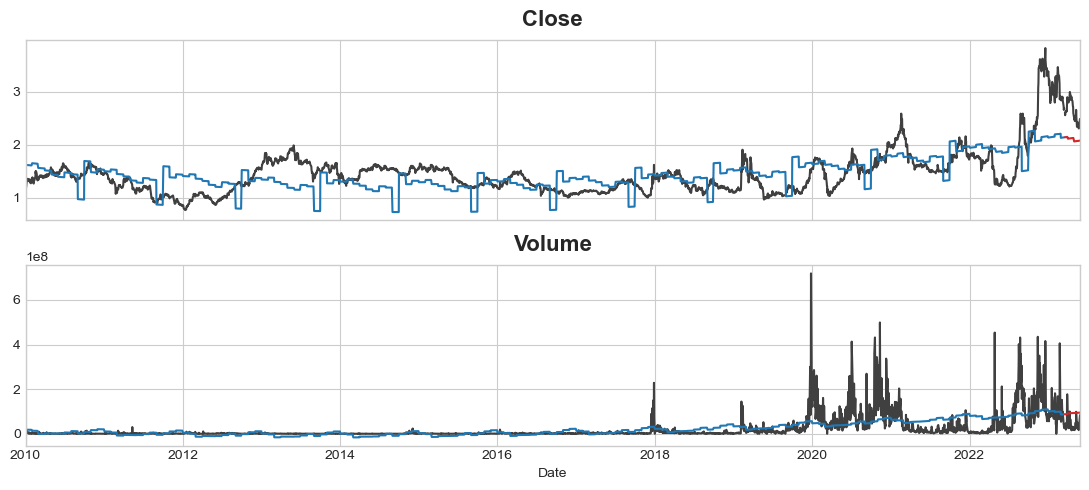

In [8]:
axs = y_train.unstack(['Columns']).plot(
    color='0.25', figsize=(11, 5), subplots=True, sharex=True,
    title=['Close', 'Volume'],
)
axs = y_test.unstack(['Columns']).plot(
    color='0.25', subplots=True, sharex=True, ax=axs,
)
axs = y_fit_boosted.unstack(['Columns']).plot(
    color='C0', subplots=True, sharex=True, ax=axs,
)
axs = y_pred_boosted.unstack(['Columns']).plot(
    color='C3', subplots=True, sharex=True, ax=axs,
)
for ax in axs: ax.legend([])